# Martin Krücke, Jana Kölher and Martin Iniguez de Onzono Muruaga Sheet 03

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile

## Exercise 5.1. Initialization.

In [2]:
def random_inv(N):
    A = np.random.uniform(0,1,size=[N,N])
    
    invertible = False
    while invertible == False: 
        try: B = np.linalg.inv(A)
        except:
            A = np.random.uniform(0,1,size=[N,N])
        else:
            invertible = True
            
    return B

### a) Load the sound files.

In [3]:
sound1 = np.array(pd.read_table("sound1.dat"))
sound1 = np.append(-np.array([0]),sound1)

sound2 = np.array(pd.read_table("sound2.dat"))
sound2 = np.append(-np.array([0]),sound2)

N = 2
f_samp = 8192  # Hz
p = 18000  # Samples
sound = np.vstack((sound1,sound2))

### b) Create a random A matrix and mix the sources.

In [4]:
A = random_inv(2)
x_val = A @ sound

### c) Remove the temporal structure.

In [5]:
# np.random.seed(0)

x_no_temp = np.apply_along_axis(np.random.permutation, axis=1, arr=x_val)

### d) Calculate the correlations.

In [6]:
def rho_calc(s,x):
    rho_out = np.cov(s,x)/(np.std(s)*np.std(x))
    return rho_out

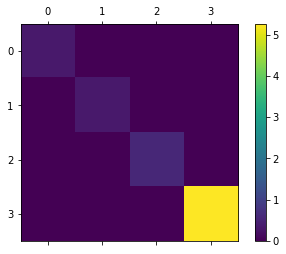

In [7]:
rho = rho_calc(sound,x_no_temp)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(rho)
fig.colorbar(cax);

### e) Center the data.

In [8]:
means = np.mean(x_no_temp,axis=0)
x_cent = x_no_temp - means

### f) Initialize the unmixing matrix W.

In [9]:
W = random_inv(2)

## Exercise 5.2. Optimization.

In [10]:
def logistic(y):
    func = 1/(1+np.exp(-y))
    return func

### a) Compute the updates matrixes.

In [11]:
def standard_grad(data,W,rate0 = 0.01):
    
    p = data.shape[1]
    N = data.shape[0]
    w_delta = np.zeros((p,N,N))
    w_all = np.empty((p,N,N))
    W_0 = W.copy()
    rate = np.empty(p)
    rate[0] = rate0
    
    for alpha in range(0,p):
        for i in range(0,N):
            for j in range(0,N):
                sums = W_0[i,:]@data[:,alpha]
                de_dw = np.linalg.inv(W_0)[j,i] + (1-2*logistic(sums))*data[j,alpha]
                w_delta[alpha,i,j] = (rate0)*de_dw
                W_0[i,j] += w_delta[alpha,i,j]

        rate0 = rate0*(0.9999999)**alpha
        rate[alpha] = rate0
        w_all[alpha,:,:]= W_0     
        
    return w_all,w_delta

def natural_grad(data,W,rate0 = 0.01):
    
    p = data.shape[1]
    N = data.shape[0]
    w_delta = np.zeros((p,N,N))
    w_all = np.empty((p,N,N))
    W_0 = W.copy()
    rate = np.empty(p)
    rate[0] = rate0
    
    for alpha in range(0,p):
        for i in range(0,N):
            for j in range(0,N):
                sums = W_0[i,:]@data[:,alpha]
                de_dw = np.linalg.inv(W_0)[j,i] + (1-2*logistic(sums))*data[j,alpha]
                w_delta[alpha,i,j] = (rate0)*de_dw
       
        W_0 += w_delta[alpha,:,:]*(W_0.T * W_0)
        rate0 = rate0*(0.9999999)**alpha
        rate[alpha] = rate0
        w_all[alpha,:,:]= W_0     
        
    return w_all,w_delta
    

In [12]:
w_stand,delta_stand = standard_grad(x_cent,W)
w_nat,delta_nat = natural_grad(x_cent,W)

In [13]:
sound_stand = w_stand[-1,:,:] @ x_val
sound_nat = w_nat[-1,:,:] @ x_val

## Exercise 5.3. Results.

### a) Plot & Play.

In [14]:
def plot_play(sound,f_samp,labels):
    s = 1/f_samp
    t= np.arange(3000,5000)*s
    plt.plot(t,sound[0,3000:5000],label=labels+'1')
    plt.plot(t,sound[1,3000:5000],label=labels+'2')
    plt.xlabel('Time')
    plt.legend()
    wavfile.write(labels+'1.wav',f_samp,sound[0,:])
    wavfile.write(labels+'2.wav',f_samp,sound[1,:])

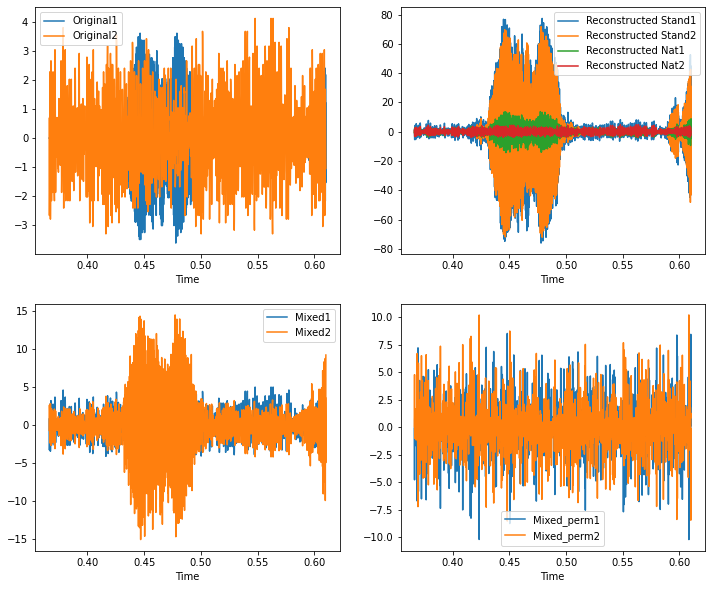

In [15]:
fig= plt.figure(figsize=(12,10))
fig.add_subplot(2,2,1)
plot_play(sound,f_samp,'Original')

fig.add_subplot(2,2,2)
plot_play(sound_stand,f_samp,'Reconstructed Stand')
plot_play(sound_nat,f_samp,'Reconstructed Nat')

fig.add_subplot(2,2,3)
plot_play(x_val,f_samp,'Mixed')

fig.add_subplot(2,2,4)
plot_play(x_cent,f_samp,'Mixed_perm')

### b) Calculate the correlations.

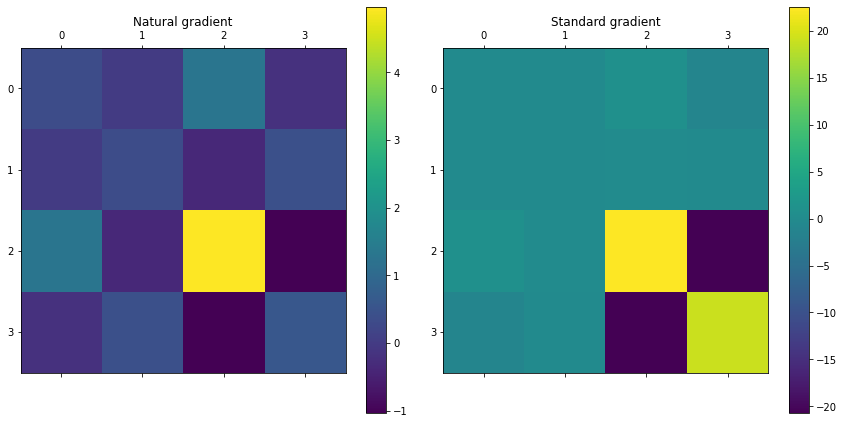

In [16]:
rho_new = rho_calc(sound,sound_nat)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.set_title('Natural gradient')
cax = ax.matshow(rho_new)
fig.colorbar(cax);

rho_new = rho_calc(sound,sound_stand)

ax = fig.add_subplot(122)
cax = ax.matshow(rho_new)
ax.set_title('Standard gradient')
fig.colorbar(cax);

fig.tight_layout()

### c) Compare convergece speeds.

In [17]:
def whitening(X):
    means = np.mean(X,axis=0)
    XCentered = X.copy()

    X = XCentered - means

    cov = np.cov(XCentered)
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.T.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

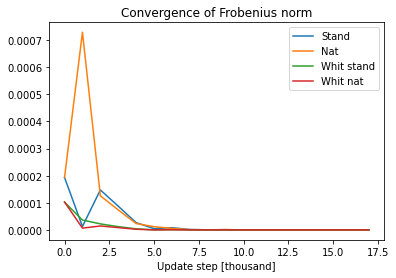

In [18]:
froben_stand = np.empty(p)
froben_nat = np.empty(p)
for i in range(0,p):
    froben_stand[i]=np.sum((delta_stand[i,:,:])**2)
    froben_nat[i]=np.sum((delta_nat[i,:,:])**2)
    
plt.plot(froben_stand[0:p-1:1000],label='Stand')
plt.plot(froben_nat[0:p-1:1000],label='Nat')

w_stand,delta_stand_wh = standard_grad(whitening(x_cent).T,W)
w_nat,delta_nat_wh = natural_grad(whitening(x_cent).T,W)

froben_stand_wh = np.empty(p)
froben_nat_wh = np.empty(p)
for i in range(0,p):
    froben_stand_wh[i]=np.sum((delta_stand_wh[i,:,:])**2)
    froben_nat_wh[i]=np.sum((delta_nat_wh[i,:,:])**2)
    
plt.plot(froben_stand_wh[0:p-1:1000],label='Whit stand')
plt.plot(froben_nat_wh[0:p-1:1000],label='Whit nat')
plt.xlabel('Update step [thousand]')
plt.title('Convergence of Frobenius norm')
plt.legend();

The natural one will take more time to find the optimal weight since the updates are normalized. The whitening case will run faster because they are oriented already in a direction and thus, little change can be made on the contribution of the x part.

### d) Plot the density of the mixed, unmixed, and true signals and interpret your results.

In [19]:
def plot_density(sound,f_samp,labels):
    s = 1/f_samp
    t= np.arange(0,sound.shape[1])*s
    plt.plot(t,sound[0,:]**2,label=labels+'1')
    plt.plot(t,sound[1,:]**2,label=labels+'2',alpha=0.5)
    plt.xlabel('Time')
    plt.legend()

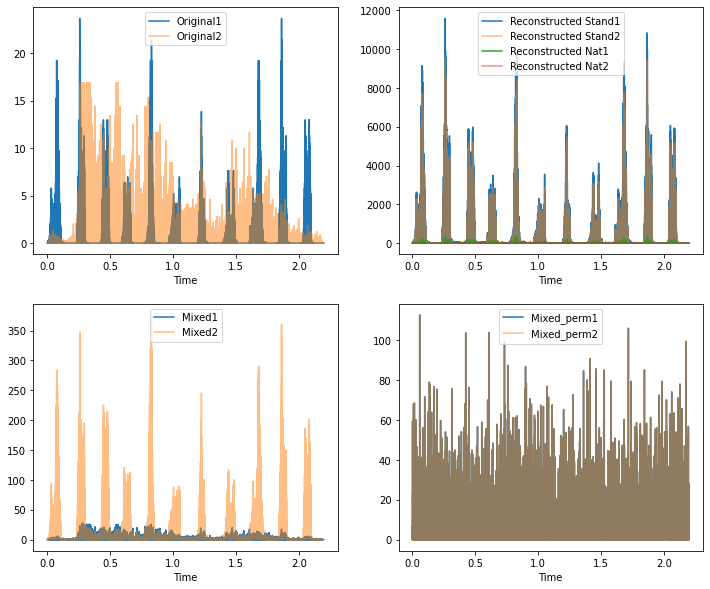

In [20]:
fig= plt.figure(figsize=(12,10))

fig.add_subplot(2,2,1)
plot_density(sound,f_samp,'Original')

fig.add_subplot(2,2,2)
plot_density(sound_stand,f_samp,'Reconstructed Stand')
plot_density(sound_nat,f_samp,'Reconstructed Nat')

fig.add_subplot(2,2,3)
plot_density(x_val,f_samp,'Mixed')

fig.add_subplot(2,2,4)
plot_density(x_cent,f_samp,'Mixed_perm')

In the reconstructed signals we can identify that for each method always one sognal resembles more of one of the original sounds. They are not perfectly reconstrucded, but for example the ~6Hz periodic bird sound is much more present in one of them (each).

In the visualization of the mixed signals we can see that the results resemble a linear combination of the two original signals. In this specific case the intermitting high amplitude parts correspond to the bird sounds, especially between 0.25s and 1s the contribution of the opera seems present (good visible in the breaks of the bird sound). However, our mixture seems to have a higher percentage (weights in mixing matrix) of the birds sounds.

As expected, the mixed permutated part does not align with the shape of the other plots, since it corresponds to a sequence with a different temporal distribution.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b99e2596-0367-4d67-802d-398a8bebc31e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>